# The Trends in Data Science

In this notebook I will try to answer what stack is on the trend among data scientist and answer questions below.


1. What data science stack is currently trending?
2. What data science stack will be the treand in near future?
3. How much average annual earning of the top stacks in data science?

## Data Understanding
To answer the questions above, luckily we have 2020 Developer Survey from Stackoverflow public data.

### Load Needed Libraries for This Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

We load Pandas, Numpy, and pyplot for this project. This libraries will be heavily used for this project

### Load the Data and Filter Needed Columns
We load the data from csv file and take only desired column for this project

As you can see below, this table already have our needed data like the database developer used, what developer type he/she is, etc.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/datasets/stackoverflow_survey_2020/survey_results_public.csv')
desired_column = ['MainBranch', 'ConvertedComp', 'Country', 'DatabaseDesireNextYear', 'DatabaseWorkedWith', 'DevType', 'EdLevel', 'Employment', 'LanguageDesireNextYear', 'LanguageWorkedWith', 'MiscTechDesireNextYear', 'MiscTechWorkedWith', 'NEWLearn', 'PlatformDesireNextYear', 'PlatformWorkedWith', 'UndergradMajor', 'WebframeDesireNextYear', 'WebframeWorkedWith', 'WorkWeekHrs', 'YearsCode', 'YearsCodePro']
df = df[desired_column]
df.head()

,MainBranch,ConvertedComp,Country,DatabaseDesireNextYear,DatabaseWorkedWith,DevType,EdLevel,Employment,LanguageDesireNextYear,LanguageWorkedWith,MiscTechDesireNextYear,MiscTechWorkedWith,NEWLearn,PlatformDesireNextYear,PlatformWorkedWith,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WorkWeekHrs,YearsCode,YearsCodePro
0,I am a developer by profession,NaN,Germany,Microsoft SQL Server,Elasticsearch;Microsoft SQL Server;Oracle,"Developer, desktop or enterprise applications;...","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Independent contractor, freelancer, or self-em...",C#;HTML/CSS;JavaScript,C#;HTML/CSS;JavaScript,.NET Core;Xamarin,.NET;.NET Core,Once a year,Android;iOS;Kubernetes;Microsoft Azure;Windows,Windows,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,50.0,36,27
1,I am a developer by profession,NaN,United Kingdom,NaN,NaN,"Developer, full-stack;Developer, mobile","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed full-time,Python;Swift,JavaScript;Swift,React Native;TensorFlow;Unity 3D,React Native,Once a year,iOS;Kubernetes;Linux;MacOS,iOS,"Computer science, computer engineering, or sof...",NaN,NaN,NaN,7,4
2,I code primarily as a hobby,NaN,Russian Federation,NaN,NaN,NaN,NaN,NaN,Objective-C;Python;Swift,Objective-C;Python;Swift,NaN,NaN,Once a decade,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
3,I am a developer by profession,NaN,Albania,NaN,NaN,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",NaN,NaN,NaN,NaN,NaN,Once a year,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,40.0,7,4
4,"I used to be a developer by profession, but no...",NaN,United States,MySQL;PostgreSQL,MySQL;PostgreSQL;Redis;SQLite,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed full-time,Java;Ruby;Scala,HTML/CSS;Ruby;SQL,Ansible;Chef,Ansible,Once a year,Docker;Google Cloud Platform;Heroku;Linux;Windows,AWS;Docker;Linux;MacOS;Windows,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,NaN,15,8


## Sliced Database for Trial (comment this line when you are ready)

In [4]:
# df = df.iloc[:200,:]

## Data Preparation
Before we can do more with this data, we have to clean the data first

### Filter Only Developer Respondent
Since we are only interested in a person who is developer, we only take "I am a developer by profession" answer in MainBranch column.

In [5]:
df = df[df['MainBranch'] == 'I am a developer by profession']

### Get Dummies from Columns with Stringified List Values
As you can see in the table, there are many data that are filled with stringified list. We need to change this raw string value into separated column so we can analyze it

#### Create Functions to Convert List to Dummy Columns
First step, we create functions to do so


In [6]:
def add_list_to_df(target_df, stack_name_list, prefix):
  '''
  INPUT:
  target_df - target dataframe to be added new row
  stack_name_list - list of stack name to be added to dataframe
  prefix - column prefix

  OUTPUT:
  new_df - dataframe with dummy columns from the list
  '''

  new_row = {}
  for stack_name in stack_name_list:
    col_name = prefix + '_' + stack_name
    
    #check if the col_name already existed in target_df, if not add new column
    if col_name not in list(target_df.columns):
      target_df[col_name] = [False]*target_df.shape[0]
    
    #set the value of the stack_name to True, leave other to to False
    new_row[col_name] = True
  
  #add new row
  target_df = target_df.append(new_row, ignore_index=True, verify_integrity=True)

  return target_df

In [7]:
def separate_column_list(df, col_name, list_sep, prefix=None):
  '''
  INPUT:
  df - pandas dataframe
  col_name - name of column which contain list that want to be separated
  list_sep - character used to separate object in the list
  prefix - prefix for the new column

  OUTPUT:
  new_df - new dataframe only contain dummy columns
  '''

  if prefix == None:
    prefix = col_name
  
  target_df = df[col_name]
  new_df = pd.DataFrame()

  for i in range(df.shape[0]):
    raw_str = target_df.iat[i]

    #skip if the value is NaN
    if type(raw_str) != str:
      continue
    
    #parse the string to list
    str_list = raw_str.split(list_sep)

    #add the value 
    new_df = add_list_to_df(new_df, str_list, prefix)
  
  return new_df

#### Create Util Functions for Future Use

In [8]:
def get_dummy_columns_name(raw_col_name, column_list):
  '''
  INPUT:
  raw_col_name - name of column before it dummified
  column_list - list of all column to search on

  OUTPUT:
  dummy_column_name_list - list of dummy column name that come from raw_col_name
  '''

  dummy_column_name_list = []
  for dummy_column in column_list:
    if raw_col_name in dummy_column:
      dummy_column_names.append(dummy_column)
  
  return dummy_column_name_list

#### Create List of Column with Stringified List Value
We save the list of each column that have the stringified list value

In [9]:
stringified_list_columns_name = ['DatabaseDesireNextYear', 'DatabaseWorkedWith', 'DevType',
  'LanguageDesireNextYear', 'LanguageWorkedWith', 'MiscTechDesireNextYear',
  'MiscTechWorkedWith', 'PlatformDesireNextYear', 'PlatformWorkedWith', 'WebframeDesireNextYear',
  'WebframeWorkedWith']

#### Run the Functions to Create Dummies for All *stringified_list_columns_name*
Then we iterate through dummified_columns to dummify the given columns



In [10]:
for column in stringified_list_columns_name:
  df = pd.concat([df.drop(axis=1, columns=column), separate_column_list(df, column, ';')],
                  axis=1)

In [11]:
df.head()

,MainBranch,ConvertedComp,Country,EdLevel,Employment,NEWLearn,UndergradMajor,WorkWeekHrs,YearsCode,YearsCodePro,DatabaseDesireNextYear_Microsoft SQL Server,DatabaseDesireNextYear_MongoDB,DatabaseDesireNextYear_Firebase,DatabaseDesireNextYear_PostgreSQL,DatabaseDesireNextYear_Cassandra,DatabaseDesireNextYear_Elasticsearch,DatabaseDesireNextYear_MariaDB,DatabaseDesireNextYear_Redis,DatabaseDesireNextYear_SQLite,DatabaseDesireNextYear_Oracle,DatabaseDesireNextYear_MySQL,DatabaseDesireNextYear_DynamoDB,DatabaseDesireNextYear_Couchbase,DatabaseDesireNextYear_IBM DB2,DatabaseWorkedWith_Elasticsearch,DatabaseWorkedWith_Microsoft SQL Server,DatabaseWorkedWith_Oracle,DatabaseWorkedWith_MariaDB,DatabaseWorkedWith_MySQL,DatabaseWorkedWith_Redis,DatabaseWorkedWith_Firebase,DatabaseWorkedWith_MongoDB,DatabaseWorkedWith_PostgreSQL,DatabaseWorkedWith_SQLite,DatabaseWorkedWith_IBM DB2,DatabaseWorkedWith_DynamoDB,DatabaseWorkedWith_Cassandra,DatabaseWorkedWith_Couchbase,"DevType_Developer, desktop or enterprise applications","DevType_Developer, full-stack",...,PlatformWorkedWith_Heroku,PlatformWorkedWith_Google Cloud Platform,PlatformWorkedWith_Kubernetes,PlatformWorkedWith_MacOS,PlatformWorkedWith_Arduino,PlatformWorkedWith_Slack Apps and Integrations,PlatformWorkedWith_Microsoft Azure,PlatformWorkedWith_IBM Cloud or Watson,WebframeDesireNextYear_ASP.NET Core,WebframeDesireNextYear_React.js,WebframeDesireNextYear_Django,WebframeDesireNextYear_Vue.js,WebframeDesireNextYear_Angular.js,WebframeDesireNextYear_Flask,WebframeDesireNextYear_jQuery,WebframeDesireNextYear_Angular,WebframeDesireNextYear_ASP.NET,WebframeDesireNextYear_Gatsby,WebframeDesireNextYear_Express,WebframeDesireNextYear_Spring,WebframeDesireNextYear_Ruby on Rails,WebframeDesireNextYear_Laravel,WebframeDesireNextYear_Symfony,WebframeDesireNextYear_Drupal,WebframeWorkedWith_ASP.NET,WebframeWorkedWith_ASP.NET Core,WebframeWorkedWith_Flask,WebframeWorkedWith_jQuery,WebframeWorkedWith_Angular,WebframeWorkedWith_Angular.js,WebframeWorkedWith_Django,WebframeWorkedWith_React.js,WebframeWorkedWith_Vue.js,WebframeWorkedWith_Gatsby,WebframeWorkedWith_Spring,WebframeWorkedWith_Express,WebframeWorkedWith_Ruby on Rails,WebframeWorkedWith_Symfony,WebframeWorkedWith_Laravel,WebframeWorkedWith_Drupal
0,I am a developer by profession,NaN,Germany,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Independent contractor, freelancer, or self-em...",Once a year,"Computer science, computer engineering, or sof...",50.0,36,27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,I am a developer by profession,NaN,United Kingdom,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed full-time,Once a year,"Computer science, computer engineering, or sof...",NaN,7,4,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,I am a developer by profession,NaN,Albania,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",NaN,Once a year,"Computer science, computer engineering, or sof...",40.0,7,4,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.

#### Dummy Columns Result
After running the data above, we need the names of each dummy columns for next step of processing

In [12]:
dummified_columns_result = []
for stringified_list_column_name in stringified_list_columns_name:
  dummified_columns_result.extend(get_dummy_columns_name(stringified_list_column_name,list(df.columns)))

### Last Step Clearing
Some of the dummified column still need to be cleared, so i clear with the below steps

#### Change Float Value to Boolean in Dummified Columns

In [13]:
for col_name in dummified_columns_result:
  df[col_name] = df[col_name].fillna(0)
  df[col_name] = df[col_name].replace({0.0: False, 1.0: True})

df.head()

,MainBranch,ConvertedComp,Country,EdLevel,Employment,NEWLearn,UndergradMajor,WorkWeekHrs,YearsCode,YearsCodePro,DatabaseDesireNextYear_Microsoft SQL Server,DatabaseDesireNextYear_MongoDB,DatabaseDesireNextYear_Firebase,DatabaseDesireNextYear_PostgreSQL,DatabaseDesireNextYear_Cassandra,DatabaseDesireNextYear_Elasticsearch,DatabaseDesireNextYear_MariaDB,DatabaseDesireNextYear_Redis,DatabaseDesireNextYear_SQLite,DatabaseDesireNextYear_Oracle,DatabaseDesireNextYear_MySQL,DatabaseDesireNextYear_DynamoDB,DatabaseDesireNextYear_Couchbase,DatabaseDesireNextYear_IBM DB2,DatabaseWorkedWith_Elasticsearch,DatabaseWorkedWith_Microsoft SQL Server,DatabaseWorkedWith_Oracle,DatabaseWorkedWith_MariaDB,DatabaseWorkedWith_MySQL,DatabaseWorkedWith_Redis,DatabaseWorkedWith_Firebase,DatabaseWorkedWith_MongoDB,DatabaseWorkedWith_PostgreSQL,DatabaseWorkedWith_SQLite,DatabaseWorkedWith_IBM DB2,DatabaseWorkedWith_DynamoDB,DatabaseWorkedWith_Cassandra,DatabaseWorkedWith_Couchbase,"DevType_Developer, desktop or enterprise applications","DevType_Developer, full-stack",...,PlatformWorkedWith_Heroku,PlatformWorkedWith_Google Cloud Platform,PlatformWorkedWith_Kubernetes,PlatformWorkedWith_MacOS,PlatformWorkedWith_Arduino,PlatformWorkedWith_Slack Apps and Integrations,PlatformWorkedWith_Microsoft Azure,PlatformWorkedWith_IBM Cloud or Watson,WebframeDesireNextYear_ASP.NET Core,WebframeDesireNextYear_React.js,WebframeDesireNextYear_Django,WebframeDesireNextYear_Vue.js,WebframeDesireNextYear_Angular.js,WebframeDesireNextYear_Flask,WebframeDesireNextYear_jQuery,WebframeDesireNextYear_Angular,WebframeDesireNextYear_ASP.NET,WebframeDesireNextYear_Gatsby,WebframeDesireNextYear_Express,WebframeDesireNextYear_Spring,WebframeDesireNextYear_Ruby on Rails,WebframeDesireNextYear_Laravel,WebframeDesireNextYear_Symfony,WebframeDesireNextYear_Drupal,WebframeWorkedWith_ASP.NET,WebframeWorkedWith_ASP.NET Core,WebframeWorkedWith_Flask,WebframeWorkedWith_jQuery,WebframeWorkedWith_Angular,WebframeWorkedWith_Angular.js,WebframeWorkedWith_Django,WebframeWorkedWith_React.js,WebframeWorkedWith_Vue.js,WebframeWorkedWith_Gatsby,WebframeWorkedWith_Spring,WebframeWorkedWith_Express,WebframeWorkedWith_Ruby on Rails,WebframeWorkedWith_Symfony,WebframeWorkedWith_Laravel,WebframeWorkedWith_Drupal
0,I am a developer by profession,NaN,Germany,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Independent contractor, freelancer, or self-em...",Once a year,"Computer science, computer engineering, or sof...",50.0,36,27,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,I am a developer by profession,NaN,United Kingdom,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed full-time,Once a year,"Computer science, computer engineering, or sof...",NaN,7,4,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
3,I am a developer by pr

#### Filter Only Data Related Respondent
Since we are only interested in Data Science, Data Analytics, ML Engineer respondents, we will only keep the row who have **'DevType_Data or business analyst'** or **'DevType_Data scientist or machine learning specialist'** value

In [14]:
df = df[(df['DevType_Data scientist or machine learning specialist'] | df['DevType_Data or business analyst'])].dropna(subset=['MainBranch'])
df[['MainBranch', 'DevType_Data scientist or machine learning specialist', 'DevType_Data or business analyst']].head()

,MainBranch,DevType_Data scientist or machine learning specialist,DevType_Data or business analyst
30,I am a developer by profession,False,True
33,I am a developer by profession,True,False
44,I am a developer by profession,False,True
49,I am a developer by profession,True,False
51,I am a developer by profession,True,True


## Descriptive Analysis
Now our data is cleaned, before jumping into modelling, I'm trying to create some descriptive analytic from our dataframe

### Currently Trending Data Science Stack

First, filter the column name that's related to the stack that mostly used by data scientist and save it to *dummified_popular_stack_columns*

In [15]:
raw_worked_col_list = ['DatabaseWorkedWith', 'LanguageWorkedWith', 'MiscTechWorkedWith',
                'PlatformWorkedWith', 'WebframeWorkedWith']
popular_stack_dummy_columns = []
for raw_col in raw_worked_col_list:
  popular_stack_dummy_columns.extend(get_dummy_columns_name(raw_col, list(df.columns)))

Second, slice the dataframe only at the column in *popular_stack_dummy_columns*

In [16]:
popular_stack_df = df[popular_stack_dummy_columns]
popular_stack_df.head()

,DatabaseWorkedWith_Elasticsearch,DatabaseWorkedWith_Microsoft SQL Server,DatabaseWorkedWith_Oracle,DatabaseWorkedWith_MariaDB,DatabaseWorkedWith_MySQL,DatabaseWorkedWith_Redis,DatabaseWorkedWith_Firebase,DatabaseWorkedWith_MongoDB,DatabaseWorkedWith_PostgreSQL,DatabaseWorkedWith_SQLite,DatabaseWorkedWith_IBM DB2,DatabaseWorkedWith_DynamoDB,DatabaseWorkedWith_Cassandra,DatabaseWorkedWith_Couchbase,LanguageWorkedWith_C#,LanguageWorkedWith_HTML/CSS,LanguageWorkedWith_JavaScript,LanguageWorkedWith_Swift,LanguageWorkedWith_Java,LanguageWorkedWith_PHP,LanguageWorkedWith_Python,LanguageWorkedWith_SQL,LanguageWorkedWith_TypeScript,LanguageWorkedWith_Bash/Shell/PowerShell,LanguageWorkedWith_Kotlin,LanguageWorkedWith_R,LanguageWorkedWith_VBA,LanguageWorkedWith_Perl,LanguageWorkedWith_C++,LanguageWorkedWith_C,LanguageWorkedWith_Haskell,LanguageWorkedWith_Ruby,LanguageWorkedWith_Rust,LanguageWorkedWith_Dart,LanguageWorkedWith_Scala,LanguageWorkedWith_Julia,LanguageWorkedWith_Assembly,LanguageWorkedWith_Go,LanguageWorkedWith_Objective-C,MiscTechWorkedWith_.NET,...,MiscTechWorkedWith_Flutter,MiscTechWorkedWith_Cordova,MiscTechWorkedWith_Keras,MiscTechWorkedWith_Xamarin,MiscTechWorkedWith_Unreal Engine,MiscTechWorkedWith_Apache Spark,MiscTechWorkedWith_Puppet,MiscTechWorkedWith_Chef,PlatformWorkedWith_Windows,PlatformWorkedWith_iOS,PlatformWorkedWith_Android,PlatformWorkedWith_Docker,PlatformWorkedWith_WordPress,PlatformWorkedWith_Linux,PlatformWorkedWith_Raspberry Pi,PlatformWorkedWith_AWS,PlatformWorkedWith_Heroku,PlatformWorkedWith_Google Cloud Platform,PlatformWorkedWith_Kubernetes,PlatformWorkedWith_MacOS,PlatformWorkedWith_Arduino,PlatformWorkedWith_Slack Apps and Integrations,PlatformWorkedWith_Microsoft Azure,PlatformWorkedWith_IBM Cloud or Watson,WebframeWorkedWith_ASP.NET,WebframeWorkedWith_ASP.NET Core,WebframeWorkedWith_Flask,WebframeWorkedWith_jQuery,WebframeWorkedWith_Angular,WebframeWorkedWith_Angular.js,WebframeWorkedWith_Django,WebframeWorkedWith_React.js,WebframeWorkedWith_Vue.js,WebframeWorkedWith_Gatsby,WebframeWorkedWith_Spring,WebframeWorkedWith_Express,WebframeWorkedWith_Ruby on Rails,WebframeWorkedWith_Symfony,WebframeWorkedWith_Laravel,WebframeWorkedWith_Drupal
30,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,True,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,True,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False
33,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,True,False,True,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False
44,False,False,False,True,False,True,False,False,False,True,False,False,False,False,True,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
49,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,Fa

Third, create sum of each stack and sort it by count and take only top 30

In [17]:
sorted_popular_stack_df = popular_stack_df.sum().sort_values(ascending=False).head(30)

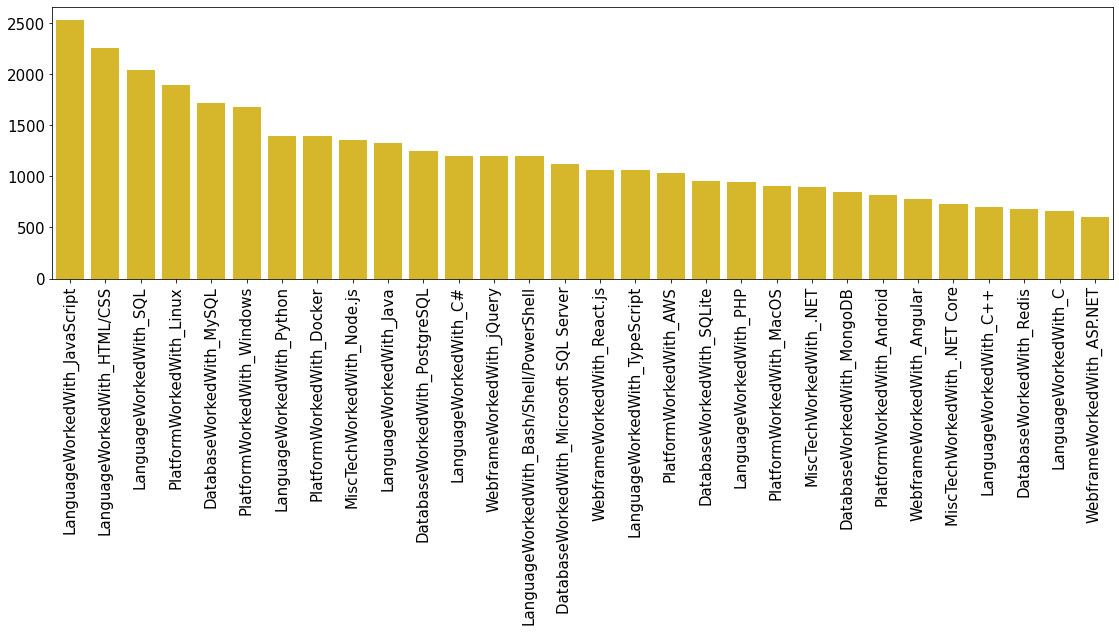

In [29]:
plt.figure(figsize=(19,5))
plt.xticks(rotation='vertical', fontsize=15.0)
plt.yticks(fontsize=15.0)
sns.barplot(x=sorted_popular_stack_df.index, y=sorted_popular_stack_df, color="#F2C80F")
plt.show()

As you can see, javascript and HTML/CSS is the most common stack to work with. It shows us that even data scientist need to have skill of web developement to publish it to top management.

But when it comes to data-related stack, SQL is the most common languange known. It infers that having SQL skill is the most important in this field since we use it many times for data preparation, wrangling and analysis.

In terms of database, MySQL is the most popular one with PostgreSQL in second place. It show us that free open source database is still the most popular compared to licensed one like MSSQL

### The Most Wanted Data Science Stack

The same as previous step, we define related column name for most wanted data science stack in the list below. And save dummy columns name in *wanted_stack_dummy_columns*

In [19]:
raw_wanted_col_list = ['DatabaseDesireNextYear', 'LanguageDesireNextYear', 'MiscTechDesireNextYear',
  'PlatformDesireNextYear', 'WebframeDesireNextYear',]

wanted_stack_dummy_columns = []
for raw_col in raw_wanted_col_list:
  wanted_stack_dummy_columns.extend(get_dummy_columns_name(raw_col, list(df.columns)))

Second, slice the dataframe only at the column in *popular_stack_dummy_columns*

In [20]:
wanted_stack_df = df[wanted_stack_dummy_columns]
wanted_stack_df.head()

,DatabaseDesireNextYear_Microsoft SQL Server,DatabaseDesireNextYear_MongoDB,DatabaseDesireNextYear_Firebase,DatabaseDesireNextYear_PostgreSQL,DatabaseDesireNextYear_Cassandra,DatabaseDesireNextYear_Elasticsearch,DatabaseDesireNextYear_MariaDB,DatabaseDesireNextYear_Redis,DatabaseDesireNextYear_SQLite,DatabaseDesireNextYear_Oracle,DatabaseDesireNextYear_MySQL,DatabaseDesireNextYear_DynamoDB,DatabaseDesireNextYear_Couchbase,DatabaseDesireNextYear_IBM DB2,LanguageDesireNextYear_C#,LanguageDesireNextYear_HTML/CSS,LanguageDesireNextYear_JavaScript,LanguageDesireNextYear_Python,LanguageDesireNextYear_Swift,LanguageDesireNextYear_Java,LanguageDesireNextYear_PHP,LanguageDesireNextYear_Rust,LanguageDesireNextYear_R,LanguageDesireNextYear_SQL,LanguageDesireNextYear_Go,LanguageDesireNextYear_TypeScript,LanguageDesireNextYear_Haskell,LanguageDesireNextYear_Ruby,LanguageDesireNextYear_Perl,LanguageDesireNextYear_C++,LanguageDesireNextYear_Bash/Shell/PowerShell,LanguageDesireNextYear_Julia,LanguageDesireNextYear_Kotlin,LanguageDesireNextYear_Assembly,LanguageDesireNextYear_C,LanguageDesireNextYear_Dart,LanguageDesireNextYear_Scala,LanguageDesireNextYear_VBA,LanguageDesireNextYear_Objective-C,MiscTechDesireNextYear_.NET Core,...,MiscTechDesireNextYear_Torch/PyTorch,MiscTechDesireNextYear_Keras,MiscTechDesireNextYear_Ansible,MiscTechDesireNextYear_Hadoop,MiscTechDesireNextYear_Apache Spark,MiscTechDesireNextYear_Cordova,MiscTechDesireNextYear_Puppet,MiscTechDesireNextYear_Chef,PlatformDesireNextYear_Android,PlatformDesireNextYear_iOS,PlatformDesireNextYear_Kubernetes,PlatformDesireNextYear_Microsoft Azure,PlatformDesireNextYear_Windows,PlatformDesireNextYear_Linux,PlatformDesireNextYear_MacOS,PlatformDesireNextYear_Slack Apps and Integrations,PlatformDesireNextYear_Raspberry Pi,PlatformDesireNextYear_AWS,PlatformDesireNextYear_Docker,PlatformDesireNextYear_WordPress,PlatformDesireNextYear_Google Cloud Platform,PlatformDesireNextYear_Arduino,PlatformDesireNextYear_Heroku,PlatformDesireNextYear_IBM Cloud or Watson,WebframeDesireNextYear_ASP.NET Core,WebframeDesireNextYear_React.js,WebframeDesireNextYear_Django,WebframeDesireNextYear_Vue.js,WebframeDesireNextYear_Angular.js,WebframeDesireNextYear_Flask,WebframeDesireNextYear_jQuery,WebframeDesireNextYear_Angular,WebframeDesireNextYear_ASP.NET,WebframeDesireNextYear_Gatsby,WebframeDesireNextYear_Express,WebframeDesireNextYear_Spring,WebframeDesireNextYear_Ruby on Rails,WebframeDesireNextYear_Laravel,WebframeDesireNextYear_Symfony,WebframeDesireNextYear_Drupal
30,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False,True,True,False
33,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False
44,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,True,True,True,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
49,False,True,False,False,False,False

Third, create sum of each stack and sort it by count and take only top 30

In [21]:
sorted_wanted_stack_df = wanted_stack_df.sum().sort_values(ascending=False).head(30)

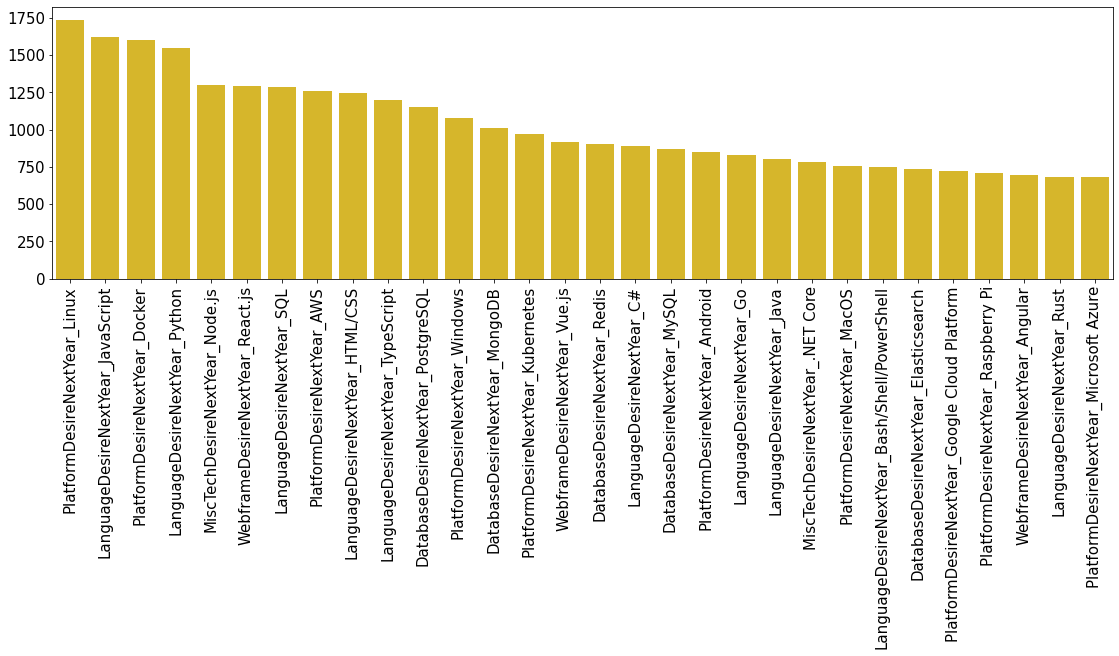

In [28]:
plt.figure(figsize=(19,5))
plt.xticks(rotation='vertical', fontsize=15.0)
plt.yticks(fontsize=15.0)
sns.barplot(x=sorted_wanted_stack_df.index, y=sorted_wanted_stack_df, color="#F2C80F")
plt.show()

In the barplot above, it shows us that Linux and Docker is the top platform with the most desired. It aligns with the trend of container and microservice architecture in the recent years.

In cloud platform, AWS is still leading as the most wanted cloud for among data scientist as it's already the leader in cloud market. It has big lead in the most wanted cloud with Google Cloud Platform in sceond place and Microsoft Azure in the third place

Supprisingly, there is javascript, Node.js and React.js as it shows that we development is still in high demand among data scientist

### Data Science Stack Top Earning

To make the dataframe easier to be analysed, we unpivot this table with *pd.melt* function

In [23]:
earning_df = df.dropna(subset=['ConvertedComp'])
earning_df = pd.melt(earning_df, id_vars='ConvertedComp',
                    value_vars=popular_stack_dummy_columns, var_name='stack')
earning_df = earning_df[earning_df['value']]

In [24]:
earning_df.head()

,ConvertedComp,stack,value
4,93000.0,DatabaseWorkedWith_Elasticsearch,True
24,1000000.0,DatabaseWorkedWith_Elasticsearch,True
28,11676.0,DatabaseWorkedWith_Elasticsearch,True
36,180000.0,DatabaseWorkedWith_Elasticsearch,True
39,81074.0,DatabaseWorkedWith_Elasticsearch,True


Since there are too many stack, we only take top 30 stack, and then drop the other stack for our visualization.

To drop the stack that are not in top 30, we create *drop_index* to store which rows has the top stack value. Then we save dataframe with only top 30 stack in *top_earning_df*

In [25]:
top_earning_stack = list(earning_df.groupby('stack').mean().sort_values('ConvertedComp', ascending=False).head(50).index)

drop_index = [False] * earning_df.shape[0]

for stack_name in top_earning_stack:
  drop_index = drop_index | (earning_df['stack'] == stack_name)

top_earning_df = earning_df[drop_index]

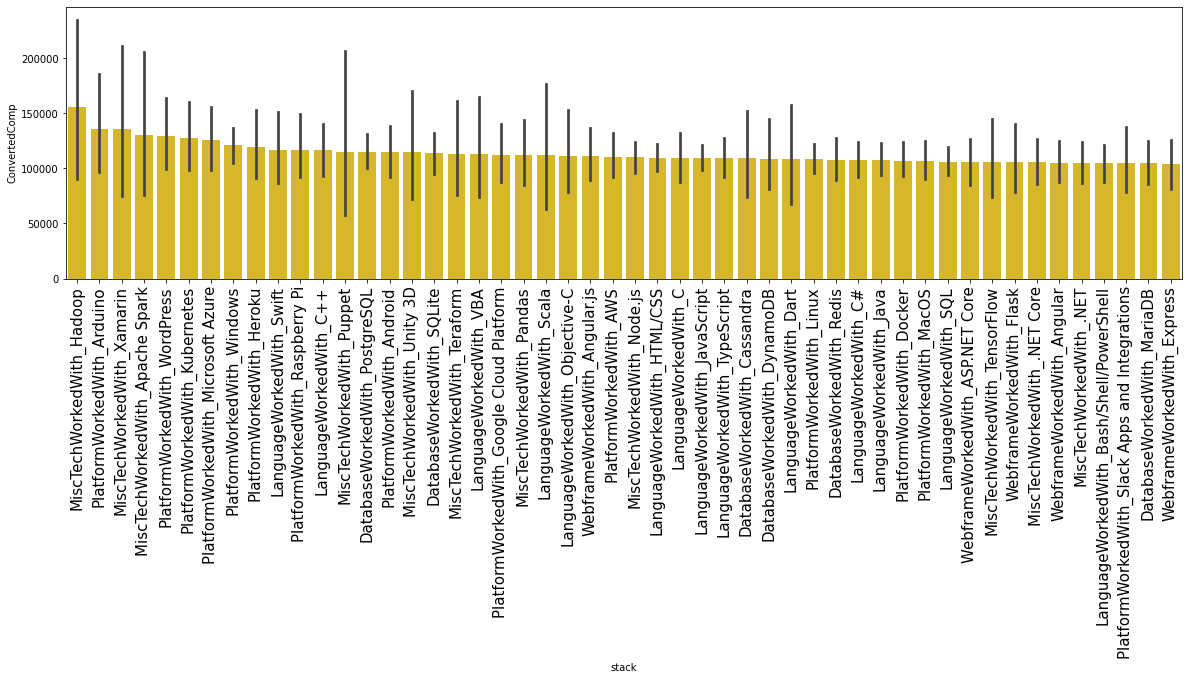

In [27]:
plt.figure(figsize=(20,5))
plt.xticks(rotation='vertical', fontsize=15.0)
sns.barplot(data = top_earning_df[['ConvertedComp','stack']], color="#F2C80F", x='stack', y='ConvertedComp',
            order=top_earning_stack)

As we can see, Hadoop skill has the highest mean of annual income across all the stacks even tough it has high standard deviation. In database, it turns out that PostgreSQL is the highest average earning

## Modelling
In this part we are trying to create a model that predict your earning based on education level, experience, and stacks

In [ ]:
# create dummy but i forgot that pandas has get_dummies. will be fixed later
ed_level_map = {
    'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)':'EdLevel_Master',
    'Some college/university study without earning a degree': 'EdLevel_Some_College',
    'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 'EdLevel_Bachelor',
    'Associate degree (A.A., A.S., etc.)': 'EdLevel_Associate',
    'Other doctoral degree (Ph.D., Ed.D., etc.)': 'EdLevel_Doctoral',
    'Professional degree (JD, MD, etc.)':'EdLevel_Professional',
    'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)':'EdLevel_Secondary',
    'Primary/elementary school':'EdLevel_Primary',
    'I never completed any formal education':'EdLevel_No_Formal_Ed'
}

for ed_level in ed_level_map.keys():
  df[ed_level_map[ed_level]] = df['EdLevel'] == ed_level



In [ ]:
modelling_columns_name = []
for col_name in ['EdLevel', 'DatabaseWorkedWith', 'MiscTechWorkedWith', 'PlatformWorkedWith']:
  modelling_columns_name.extend(get_dummy_columns_name(col_name, list(df.columns)))

modelling_columns_name.append('ConvertedComp')

In [ ]:
modelling_df = df.dropna(subset=['ConvertedComp'])[modelling_columns_name]
x_train, x_test, y_train, y_test = train_test_split(modelling_df.drop(columns=['ConvertedComp','EdLevel']), 
  modelling_df['ConvertedComp'], test_size=0.25)

In [ ]:
lm_model = LinearRegression(normalize=True)
lm_model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [ ]:
y_test_preds = lm_model.predict(x_train)
r2_test = r2_score(y_train, y_test_preds)

r2_test

0.02903259214535081